# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
In 2-4 sentences, explain the kind of problem you want to look at and the datasets you will be wrangling for this project.

*FILL IN:* I am looking to compare how the fluctuation of various stock indexes attributed to reported GDP on an annual basis for the years 2020 - 2023. I believe that using the Bureau of Economic Analysis for federal government reporting of annualized GDP by industrial sector will be the flagship of my data, with fill-ins and granularity from the large kaggle dataset of all stock ticker fluctuations daily since 1960 for the delta of high - low price; finally, the nasdaq data will help tie this whole thing together by having an standardized model of what stock tickers belong to each industry and then comparing the largest and median market cap companies of each industry.

### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

Type: CSV file

Method: API from Bureau of Economic Analysis https://apps.bea.gov/API/signup/

Dataset variables:

*   **Variable** **1** Industry (returned as an int value from BEA, will need to modify to compare with kaggle stock data)
*   **Variable** **2** DataValue - the amount of GDP generated by the industry across the timeframe specified.

In [6]:
# getting all imports squared away
import requests as req
import pandas as pd
import zipfile
import os
import shutil
import json
!pip install kaggle


Defaulting to user installation because normal site-packages is not writeable


In [7]:
api_key = "E202F759-759F-424F-BEBA-158DCD981AAA"
base_url = "https://apps.bea.gov/api/data/"

# Parameters for the API request
params = {
    "UserID": api_key,          # Your API key
    "method": "GetData",        # API method
    "datasetname": "GDPbyIndustry",  # Dataset
    "Frequency": "A",           # Annual data (use "Q" for quarterly)
    "Year": "2020,2021,2022,2023",        # Data from 2010 to 2023
    "Industry": "ALL",          # Retrieve data for all industries
    "TableID": "6",             # TableID for value-added contributions (GDP by industry)
    "ResultFormat": "JSON"      # Request data in JSON format
}

# Send the API request
response = req.get(base_url, params=params)

# Check for a successful response
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    # Extract the relevant data from the response
    results = data['BEAAPI']['Results']
    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(results)
    # Display the DataFrame
else:
    print(f"API request failed with status code: {response.status_code}")
    print(response.text)

# Extract the nested "Data" column from the DataFrame
nested_data = df.loc[0, "Data"]  # Extract the list of dictionaries in the "Data" column

# Convert the nested data into a DataFrame
bea_df = pd.DataFrame(nested_data)

# Preview the flattened data
print(bea_df.head())

# Save to CSV for later processing, if needed
bea_df.to_csv("bea_gdp_by_industry_raw.csv", index=False)

# Display the full DataFrame's structure to ensure all columns are present
print(bea_df.info())

  TableID Frequency  Year Quarter Industry  \
0       6         A  2020    2020       11   
1       6         A  2020    2020       11   
2       6         A  2020    2020       11   
3       6         A  2020    2020       11   
4       6         A  2020    2020    111CA   

                              IndustrYDescription DataValue NoteRef  
0  Taxes on production and imports less subsidies     -34.9       6  
1                       Compensation of employees      60.7       6  
2     Agriculture, forestry, fishing, and hunting     162.9       6  
3                         Gross operating surplus     137.1       6  
4  Taxes on production and imports less subsidies     -34.7       6  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TableID              1584 non-null   object
 1   Frequency            1584 non-null   object
 

#### Dataset 2

Type: CSV file

Method: Downloaded programmatically from Kaggle

Dataset variables:

*   **Variable 1** volume of stock trade, annualized
*   **Variable 2** Delta between high and low on an anual basis, with a look at positive change to indicate gdp growth, or negative change to indicate gdp shrinkage.

Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

In [9]:
# Define the path to the downloaded ZIP file and the extraction directory
zip_file = "9000-tickers-of-stock-market-data-full-history.zip"
extract_dir = "9000-tickers-stock-data"
target_dir = "."
csv_file = os.path.join(target_dir, "all_stock_data.csv")

# Check if the CSV file already exists
if not os.path.exists(csv_file):
    # Download the Kaggle dataset
    !kaggle datasets download -d jakewright/9000-tickers-of-stock-market-data-full-history

    # Create the extraction directory if it doesn't exist
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"Files extracted to: {extract_dir}")

    # List the extracted files to confirm
    extracted_files = os.listdir(extract_dir)
    print("Extracted files:")
    for file in extracted_files:
        print(file)

    # Move the specific file up one directory
    source_file = os.path.join(extract_dir, "all_stock_data.csv")
    target_file = os.path.join(target_dir, "all_stock_data.csv")
    if os.path.exists(source_file):
        shutil.move(source_file, target_file)
        print(f"Moved {source_file} to {target_file}")
    else:
        print(f"{source_file} does not exist")

    # Delete the ZIP file and the extraction directory
    if os.path.exists(zip_file):
        os.remove(zip_file)
        print(f"Deleted {zip_file}")

    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
        print(f"Deleted directory {extract_dir}")
else:
    print(f"{csv_file} already exists, skipping download.")

.\all_stock_data.csv already exists, skipping download.


In [3]:
kag_df = pd.read_csv("9000-tickers-stock-data/all_stock_data.csv" , index_col=0)
kag_df.head()

,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
1962-01-02,ED,0.0,0.265828,0.261788,0.261788,25600.0,0.0,0.0
1962-01-02,CVX,0.0,0.046809,0.046069,0.046809,105840.0,0.0,0.0
1962-01-02,GD,0.0,0.210033,0.203061,0.208290,2648000.0,0.0,0.0
1962-01-02,BP,0.0,0.141439,0.139528,0.139528,77440.0,0.0,0.0
1962-01-02,MSI,0.0,0.764923,0.745254,0.751810,65671.0,0.0,0.0


#### Dataset 3

Type: CSV file

Method: Manually downloaded from https://www.nasdaq.com/market-activity/stocks/screener

Dataset variables:

*   **Variable 1** Stock ticker, same as kaggle data
*   **Variable 2** Sector/Industry, same as BEA data. 

- This dataset is downloaded inorder to act as a middleman of sorts between the two other datasets. The BEA offers holistic views of entire industries, and the kaggle dataset offers view of individual stocks on a day-by-day change. This dataset will offer a way to perform joins and other data-wrangling steps on similar tables

In [19]:
# Define the URL and headers
url = "https://api.nasdaq.com/api/screener/stocks?tableonly=false&limit=25&download=true"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Define the file name
file_name = "nasdaq_data.csv"

#read the raw content of nasdaq file
def save_nasdaq_data(path_to_file):
    with open(path_to_file, 'r') as file:
        raw_content = file.read()
    # parse the json struct
    try:
        nasdaq_data = json.loads(raw_content)
        # extract the data
        rows = nasdaq_data['data']['rows']
        # create a DataFrame
        nasdaq_df = pd.DataFrame(rows)
        
        # display DataFrame
        nasdaq_columns = nasdaq_df.columns.tolist()
        nasdaq_sample = nasdaq_df.head()
        
        print(nasdaq_columns,nasdaq_sample)
        return nasdaq_df
    except Exception as e:
        f"Error parsing nasdaq file: {e}"

# Check if the file exists and load immediately if it does
if os.path.exists(file_name):
    print(f"{file_name} already exists. Loading from disk...")
    nasdaq_df = save_nasdaq_data(file_name)
else:
    # Make the GET request if the file does not exist
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # Save the response content to a CSV file
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"Data successfully downloaded and saved to {file_name}")

        # Load the newly downloaded CSV
        nasdaq_df = save_nasdaq_data(file_name)
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")



nasdaq_data.csv already exists. Loading from disk...
['symbol', 'name', 'lastsale', 'netchange', 'pctchange', 'volume', 'marketCap', 'country', 'ipoyear', 'industry', 'sector', 'url']   symbol                                               name lastsale  \
0      A             Agilent Technologies Inc. Common Stock  $152.45   
1     AA                    Alcoa Corporation Common Stock    $37.35   
2   AACG   ATA Creativity Global American Depositary Shares  $0.9128   
3   AACT  Ares Acquisition Corporation II Class A Ordina...  $11.005   
4   AADI                  Aadi Bioscience Inc. Common Stock    $3.03   

  netchange pctchange    volume       marketCap        country ipoyear  \
0     -0.15   -0.098%   1332026  43539003790.00  United States    1999   
1     -1.43   -3.687%  11771833   9649552826.00  United States    2016   
2     0.024     2.70%      2788     29209719.00          China    2008   
3    -0.005   -0.045%      9682            0.00                   2023   
4      0.04  

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:

In [24]:
#FILL IN - Inspecting the dataframe programmatically
# Check for missing values
print("NASDAQ missing values")
# Check for missing values in NASDAQ DataFrame
missing_values = nasdaq_df.isnull().sum()

# Check data types of columns
data_types = nasdaq_df.dtypes

# Display a summary of missing values and data types
missing_values, data_types

NASDAQ missing values


(symbol       0
 name         0
 lastsale     0
 netchange    0
 pctchange    0
 volume       0
 marketCap    0
 country      0
 ipoyear      0
 industry     0
 sector       0
 url          0
 dtype: int64,
 symbol       object
 name         object
 lastsale     object
 netchange    object
 pctchange    object
 volume       object
 marketCap    object
 country      object
 ipoyear      object
 industry     object
 sector       object
 url          object
 dtype: object)

C:\Users\pinag\AppData\Local\Temp\ipykernel_12276\3575262023.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=nasdaq_df.dtypes, palette="viridis")


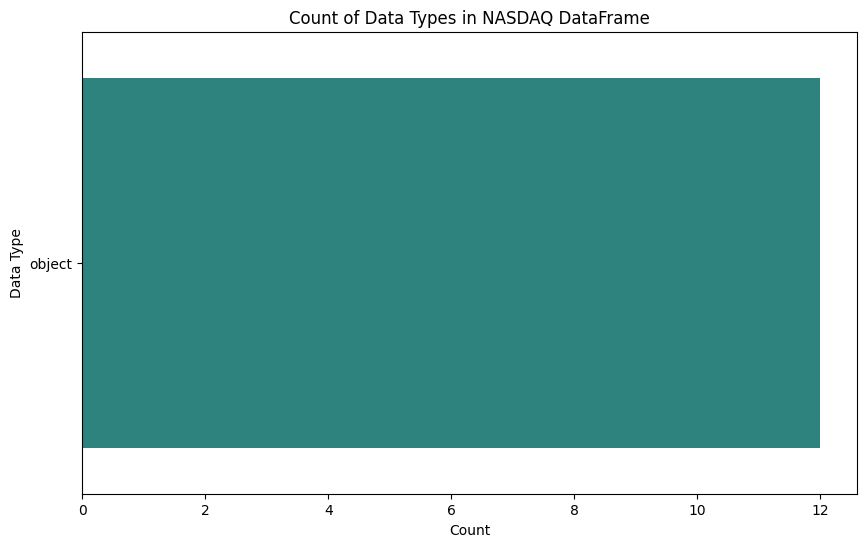

In [27]:
#FILL IN - Inspecting the dataframe visually
# Visualize outliers
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize data types
plt.figure(figsize=(10, 6))
sns.countplot(y=nasdaq_df.dtypes, palette="viridis")
plt.title("Count of Data Types in NASDAQ DataFrame")
plt.xlabel("Count")
plt.ylabel("Data Type")
plt.show()

**Issue 1: Data Types**

#### Assessment:

- Programmatically: Use `.dtypes` to check data types of columns
- Visually: Plot a heatmap or summary table to show where missing data exists.

**Justification**: Several columns that should be numeric, such as `lastsale`, `netchange`, `pctchange`, `volume`, and `marketCap`, currently all are stored as **objects (strings)**.

### Quality Issue 2:

In [ ]:
#FILL IN - Inspecting the dataframe visually

In [ ]:
#FILL IN - Inspecting the dataframe programmatically

**Issue and justification**:
 - **Sector/Industry Mapping**: The BEA data is industry-specific, while the Kaggle data uses tickers. We may need a mapping (e.g., which tickers belong to which sectors/industries).

### Tidiness Issue 1:

In [ ]:
#FILL IN - Inspecting the dataframe visually

In [ ]:
#FILL IN - Inspecting the dataframe programmatically

Issue and justification: *FILL IN*

### Tidiness Issue 2: 

In [ ]:
#FILL IN - Inspecting the dataframe visually

In [ ]:
#FILL IN - Inspecting the dataframe programmatically

Issue and justification: *FILL IN*

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [ ]:
# FILL IN - Make copies of the datasets to ensure the raw dataframes 
# are not impacted

### **Quality Issue 1: FILL IN**

In [ ]:
# FILL IN - Apply the cleaning strategy

In [ ]:
# FILL IN - Validate the cleaning was successful

Justification: *FILL IN*

### **Quality Issue 2: FILL IN**

In [ ]:
#FILL IN - Apply the cleaning strategy

In [ ]:
#FILL IN - Validate the cleaning was successful

Justification: *FILL IN*

### **Tidiness Issue 1: FILL IN**

In [ ]:
#FILL IN - Apply the cleaning strategy

In [ ]:
#FILL IN - Validate the cleaning was successful

Justification: *FILL IN*

### **Tidiness Issue 2: FILL IN**

In [1]:
#FILL IN - Apply the cleaning strategy

In [2]:
#FILL IN - Validate the cleaning was successful

Justification: *FILL IN*

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [ ]:
#FILL IN - Remove unnecessary variables and combine datasets

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [ ]:
#FILL IN - saving data

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* FILL IN from answer to Step 1

In [ ]:
#Visual 1 - FILL IN

*Answer to research question:* FILL IN

In [ ]:
#Visual 2 - FILL IN

*Answer to research question:* FILL IN

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* FILL IN